In [1]:
import numpy as np
import pandas as pd 

# <center> Wczytywanie danych </center>

In [2]:
df10=pd.read_csv('Challenger_Ranked_Games_10minute.csv')
df15=pd.read_csv('Challenger_Ranked_Games_15minute.csv')

print(df10.shape)
print(df15.shape,"\n")
print(df10.head,"\n")
print(df15.head)

(26409, 51)
(26834, 51) 

<bound method NDFrame.head of            gameId  blueWins  blueTotalGolds  blueCurrentGolds  blueTotalLevel  \
0      4247263043         0           14870              2889              32   
1      4247155821         1           14497              2617              33   
2      4243963257         0           15617              1757              34   
3      4241678498         0           15684              1439              35   
4      4241538868         1           17472              3512              35   
...           ...       ...             ...               ...             ...   
26404  4143231833         0           16762              5072              36   
26405  4157911901         0           35765              1440              39   
26406  3764171638         0           15712              4137              34   
26407  4110201724         1           15850              3220              33   
26408  4100240254         1           16103          

<br><br><br>
# <center> Przygotowanie danych </center>

Pozbywamy się zbędnych kolumn:<br>
-blueAvgLevel: jest równa blueTotalLevel/5<br>
-blueFirstTowerLane: kolumna tekstowa<br>
-blueTowerKills: równa blueTopTowerKills+blueMidTowerKills+blueBotTowerKills<br>
-blueFirstDragon: w 10 minucie równa blueDragon<br>
-blueDragnoType: kolumna tekstowa<br>
-redWins: równa 1-blueWins<br>
-redAvgLevel: równa redTotalLevel/5<br>
-redFirstTowerLane: kolumna tekstowa<br>
-redTowerKills: równa redTopTowerKills+redMidTowerKills+redBotTowerKills<br>
-redFirstDragon: w 10 minucie równa redDragon<br>
-redDragnoType: kolumna tekstowa<br>
-blueFirstBlood: zawsze równa 0<br>
-redFirstBlood: zawsze równa 0<br><br><br>

Pozbywamy się potencjalnie błędnych wierszy:<br>
-w zbiorze danych z 10 minuty zdarzało się, że suma wartości blueDragon i redDragon była większa niż 1, co jest niemożliwe, ponieważ smok pojawia się po 5 minutach i odradza się co 5. Analogicznie ze zbioru danych z 15 minuty usuwamy dane z sumą tych kolumn większą niż 2<br>
-w zbiorze danych z 15 minuty zdarzało się, że wartość blueCurrentGolds lub redCurrentGolds była o wiele mniejsza od 0, co również jest niemożliwe (niewielkie wartości poniżej 0 są możliwe dzięki runie "Future's market")<br>
-gameId czasami się powtarzało

In [3]:
drop_list=['blueAvgLevel','blueFirstTowerLane','blueTowerKills','blueFirstDragon','blueDragnoType','redWins','redAvgLevel','redFirstTowerLane','redTowerKills','redFirstDragon','redDragnoType','blueFirstBlood','redFirstBlood']
df10=df10.drop(drop_list,axis=1)

df10=df10[df10['blueDragon']+df10['redDragon']<2]
df15=df15[df15['blueDragon']+df15['redDragon']<3]

df15=df15[df15['blueCurrentGolds']>-1000]
df15=df15[df15['redCurrentGolds']>-1000]

df10=df10.drop_duplicates(subset=["gameId"], keep=False)
df15=df15.drop_duplicates(subset=["gameId"], keep=False)

print(df10.shape)
print(df15.shape)


(26159, 38)
(26475, 51)


Tworzymy dataframe'a dfGoldDiff15 złożonego z dataframe'a z 10 minuty i kolumny 'goldDifferenceAt15' z dataframe'a z 15 minuty.<br>
Usuwamy kolumnę gameId jako niepredykcyjną oraz blueWins jako informację z przyszłości

In [4]:
df_pom=df15[['gameId','blueTotalGolds','redTotalGolds']]
df_pom=df_pom.assign(goldDifferenceAt15=df_pom['blueTotalGolds']-df_pom['redTotalGolds'])
dfGoldDiff15=pd.merge(df10,df_pom[['gameId','goldDifferenceAt15']],how='inner',on='gameId')
dfGoldDiff15=dfGoldDiff15.drop(['gameId','blueWins'],axis=1)

X = dfGoldDiff15.drop(["goldDifferenceAt15"],axis=1)
y = dfGoldDiff15["goldDifferenceAt15"]
print(X.shape)
print(y.shape)

(25963, 36)
(25963,)


<br><br><br>
# <center> Wizulalizacja danych </center>

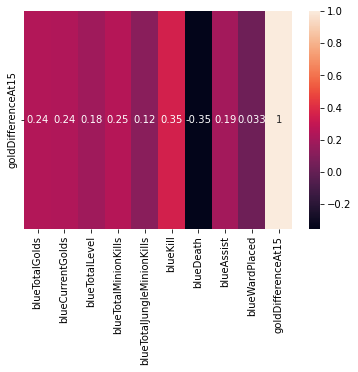

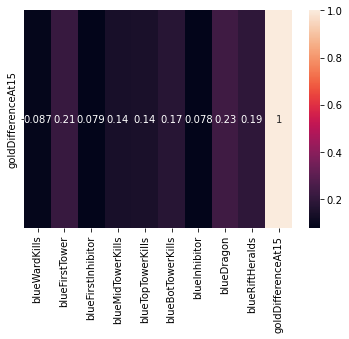

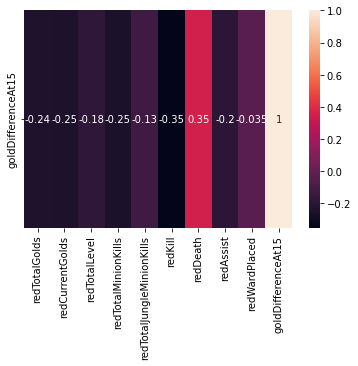

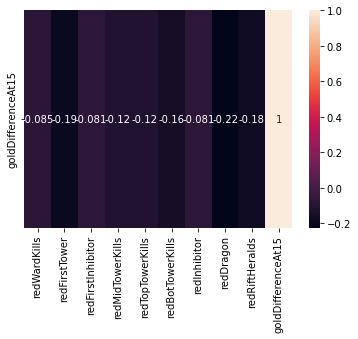

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
heat1=dfGoldDiff15[dfGoldDiff15.keys()[0:9].append(dfGoldDiff15.keys()[36:37])]
heat2=dfGoldDiff15[dfGoldDiff15.keys()[9:18].append(dfGoldDiff15.keys()[36:37])]
heat3=dfGoldDiff15[dfGoldDiff15.keys()[18:27].append(dfGoldDiff15.keys()[36:37])]
heat4=dfGoldDiff15[dfGoldDiff15.keys()[27:37]]
sns.heatmap(heat1.corr().loc[['goldDifferenceAt15'],:], annot=True)
plt.show()
sns.heatmap(heat2.corr().loc[['goldDifferenceAt15'],:], annot=True)
plt.show()
sns.heatmap(heat3.corr().loc[['goldDifferenceAt15'],:], annot=True)
plt.show()
sns.heatmap(heat4.corr().loc[['goldDifferenceAt15'],:], annot=True)
plt.show()

<br><br><br>
# <center> Regresja </center>

In [8]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from timeit import default_timer as timer

seed=123
kfold = model_selection.KFold(n_splits=5)

In [7]:
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.20)

In [8]:
%store X_train
%store X_test
%store y_train
%store y_test

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)


In [6]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

In [9]:
start = timer()
grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3]},
                    cv=kfold,
                    refit=True)
grid_1.fit(X_train, y_train)
end = timer()
print(end - start)
%store grid_1

2536.497104
Stored 'grid_1' (GridSearchCV)


In [16]:
start = timer()
grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'ridge__alpha': [0.1, 1, 10, 100]},
                    cv=kfold,
                    refit=True)
grid_2.fit(X_train, y_train)
end = timer()
print(end - start)
%store grid_2

C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.52617e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.52935e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.53023e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.52309e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-

14052.224403400003
Stored 'grid_2' (GridSearchCV)


In [11]:
start = timer()
grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'lasso__alpha': [1000,10000,100000]},
                    cv=kfold,
                    refit=True)
grid_3.fit(X_train, y_train)
end = timer()
print(end - start)
%store grid_3

C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.483e+10, tolerance: 4.750e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.437e+10, tolerance: 4.708e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.616e+10, tolerance: 4.742e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.667e+10, tolerance: 4.756e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

2227.2239566000007
Stored 'grid_3' (GridSearchCV)


C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.906e+10, tolerance: 5.915e+07
  model = cd_fast.enet_coordinate_descent(


In [12]:
start = timer()
grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'elasticnet__alpha': [1000,10000,100000]},
                    cv=kfold,
                    refit=True)
grid_4.fit(X_train, y_train)
end = timer()
print(end - start)
%store grid_4

C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.474e+10, tolerance: 4.750e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.429e+10, tolerance: 4.708e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.582e+10, tolerance: 4.742e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.634e+10, tolerance: 4.756e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

2297.6446252000023
Stored 'grid_4' (GridSearchCV)


C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.876e+10, tolerance: 5.915e+07
  model = cd_fast.enet_coordinate_descent(


In [11]:
grid_5 = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [10000,100000,1000000],
                               "gamma": [1e-09,1e-08,1e-07]},
                               cv=kfold,
                               refit=True)
grid_5.fit(X_train, y_train)
%store grid_5

Stored 'grid_5' (GridSearchCV)


In [10]:
grid_6 = GridSearchCV(RandomForestRegressor(max_depth=10,max_features=1,n_estimators=100,random_state=3),
                   param_grid={"max_depth": [10 ,100,1000],
                               "n_estimators": [100,300,1000],
                               "max_features":['auto']},
                               cv=kfold,
                               refit=True)
grid_6.fit(X_train, y_train)
%store grid_6

Stored 'grid_6' (GridSearchCV)


In [14]:
%store -r grid_1
%store -r grid_2
%store -r grid_3
%store -r grid_4
%store -r grid_5
%store -r grid_6

C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVR from version 0.24.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.1.0. This might lead to breaking c

In [18]:
print(grid_1.best_params_)
print(grid_2.best_params_)
print(grid_3.best_params_)
print(grid_4.best_params_)
print(grid_5.best_params_)
print(grid_6.best_params_)

{'polynomialfeatures__degree': 1}
{'polynomialfeatures__degree': 1, 'ridge__alpha': 10}
{'lasso__alpha': 10000, 'polynomialfeatures__degree': 2}
{'elasticnet__alpha': 10000, 'polynomialfeatures__degree': 2}
{'C': 1000000, 'gamma': 1e-09}
{'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1000}


In [17]:
models = []
models.append(grid_1.best_estimator_)
models.append(grid_2.best_estimator_)
models.append(grid_3.best_estimator_)
models.append(grid_4.best_estimator_)
models.append(grid_5.best_estimator_)
models.append(grid_6.best_estimator_)
r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for model in models:
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))
d = {'r2': r2, 
     'expl_var_score': explained_variance_score, 
     'med_abs_err': median_absolute_error,
     'mean_sqr_err' : mean_squared_error,
     'mean_abs_err' : mean_absolute_error,
    }
dfwynik = pd.DataFrame(data=d)
dfwynik.insert(loc=0, column='Method', value=['LR','Ridge','Lasso','ElasNet','SVR','RFR'])
print (dfwynik)

C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\Bloczek\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  w

    Method        r2  expl_var_score  med_abs_err  mean_sqr_err  mean_abs_err
0       LR  0.764808        0.764810  1743.223850  6.932181e+06   2082.208294
1    Ridge  0.764788        0.764791  1741.791668  6.932746e+06   2082.412655
2    Lasso  0.767475        0.767475  1723.000148  6.853548e+06   2069.878604
3  ElasNet  0.767853        0.767853  1716.940926  6.842423e+06   2067.932721
4      SVR  0.759938        0.759949  1775.046549  7.075704e+06   2104.855763
5      RFR  0.747987        0.747991  1785.527000  7.427947e+06   2142.258640
